# Proyecto de Regresión: Dataset Iris
---

### Equipo :
* Francisco Tinoco
* Juan Pedro Ley


## Contenido
1. Análisis del Dataset
2. Modelo Propuesto
3. Pipeline
4. Ajuste de Modelos y Comparaciones
5. Análisis de Significancia
6. Conclusiones
7. Referencias

---
# 1. Análisis del Dataset

## 1.1 ¿De dónde viene?

El dataset Iris fue introducido por el estadístico y biólogo británico **Ronald Fisher** en su paper de 1936 titulado *"The use of multiple measurements in taxonomic problems"*. Los datos fueron recolectados por **Edgar Anderson** para cuantificar la variación morfológica de flores Iris de tres especies relacionadas.

El dataset está disponible públicamente en el **UCI Machine Learning Repository** y en **Kaggle**.

## 1.2 ¿Qué contiene?

El dataset contiene **150 registros** con **5 atributos**:
- **SepalLengthCm:** Longitud del sépalo en centímetros
- **SepalWidthCm:** Ancho del sépalo en centímetros
- **PetalLengthCm:** Longitud del pétalo en centímetros
- **PetalWidthCm:** Ancho del pétalo en centímetros
- **Species:** Especie de la flor (Iris-setosa, Iris-versicolor, Iris-virginica)

Hay 50 muestras de cada una de las 3 especies.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [2]:
datos = pd.read_csv('Data/IRIS.csv')
datos.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [ ]:
#Información básica
print("Tamaño del dataset:", datos.shape)
print("\nTipos de datos:")
print(datos.dtypes)

Tamaño del dataset: (150, 5)

Tipos de datos:
sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
species          object
dtype: object


In [5]:
datos.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [7]:
#Distribución de especies
print("Distribución de especies:")
print(datos['species'].value_counts())

Distribución de especies:
species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64


## 1.3 ¿Qué información dan las muestras?

Cada muestra representa una flor Iris individual con sus medidas físicas:
- Las dimensiones del **sépalo** (parte verde que protege la flor)
- Las dimensiones del **pétalo** (parte colorida de la flor)
- La **especie** a la que pertenece

Esta información permite estudiar relaciones entre las características físicas de las flores.

## 1.4 ¿Qué se quiere analizar?

El objetivo es realizar **regresiones** para predecir características numéricas de las flores a partir de otras características. Específicamente:

1. **Predecir PetalLengthCm** a partir de las demás variables
2. **Predecir PetalWidthCm** a partir de las demás variables  
3. **Predecir SepalLengthCm** a partir de las demás variables

También analizaremos qué factores son estadísticamente significativos para cada predicción.

## 1.5 ¿Qué variables se tienen que transformar?

### Variables a transformar:

1. **Id:** Se elimina porque es solo un identificador, no aporta información predictiva.

2. **Species:** Es una variable categórica (texto). Se debe convertir a variables dummy (one-hot encoding) para poder usarla en regresión.

### Transformaciones a usar:

- **One-Hot Encoding** para Species → Crear columnas: Species_versicolor, Species_virginica (Setosa será la categoría base)
- **Escalamiento StandardScaler** para las variables numéricas (importante para modelos penalizados)

## 1.6 ¿Qué resultado se podría encontrar?

Se espera encontrar:

1. **Relaciones fuertes entre dimensiones de pétalos:** El largo y ancho de los pétalos probablemente están muy correlacionados.

2. **Influencia de la especie:** Las diferentes especies tienen tamaños característicos, por lo que Species debería ser un factor significativo.

3. **Menor correlación con sépalos:** Las dimensiones del sépalo podrían tener menor poder predictivo sobre los pétalos.

4. **Modelos con buen R²:** Dado que las medidas físicas están relacionadas, se esperan valores de R² moderados a altos.

---
# 2. Modelo Propuesto

Se proponen **3 modelos** diferentes, cada uno con **4 versiones**:

### Modelo 1: Predecir PetalLengthCm
$$\text{PetalLength} = \beta_0 + \beta_1(\text{SepalLength}) + \beta_2(\text{SepalWidth}) + \beta_3(\text{PetalWidth}) + \beta_4(\text{Versicolor}) + \beta_5(\text{Virginica})$$

### Modelo 2: Predecir PetalWidthCm
$$\text{PetalWidth} = \beta_0 + \beta_1(\text{SepalLength}) + \beta_2(\text{SepalWidth}) + \beta_3(\text{PetalLength}) + \beta_4(\text{Versicolor}) + \beta_5(\text{Virginica})$$

### Modelo 3: Predecir SepalLengthCm
$$\text{SepalLength} = \beta_0 + \beta_1(\text{SepalWidth}) + \beta_2(\text{PetalLength}) + \beta_3(\text{PetalWidth}) + \beta_4(\text{Versicolor}) + \beta_5(\text{Virginica})$$

### Versiones de cada modelo:
1. **Sin penalización:** Regresión lineal ordinaria (OLS)
2. **Ridge (L2):** Penaliza $\sum \beta_j^2$
3. **Lasso (L1):** Penaliza $\sum |\beta_j|$
4. **ElasticNet:** Combinación de L1 y L2

---
# 3. Pipeline

```
┌─────────────────────────────────────────────────────────────────────────────┐
│                              PIPELINE DE REGRESIÓN                          │
└─────────────────────────────────────────────────────────────────────────────┘

┌──────────────┐    ┌──────────────┐    ┌──────────────┐    ┌──────────────┐
│  1. CARGAR   │───▶│  2. LIMPIAR  │───▶│ 3. TRANSFOR- │───▶│ 4. SEPARAR   │
│    DATOS     │    │    DATOS     │    │    MAR       │    │   VARIABLES  │
│              │    │              │    │              │    │              │
│ - Leer CSV   │    │ - Eliminar   │    │ - One-Hot    │    │ - X (entrada)│
│              │    │   columna Id │    │   Encoding   │    │ - y (salida) │
│              │    │ - Verificar  │    │   (Species)  │    │              │
│              │    │   nulos      │    │              │    │              │
└──────────────┘    └──────────────┘    └──────────────┘    └──────────────┘
                                                                   │
                                                                   ▼
┌──────────────┐    ┌──────────────┐    ┌──────────────┐    ┌──────────────┐
│  8. COMPARAR │◀───│ 7. CALCULAR  │◀───│  6. AJUSTAR  │◀───│ 5. TRAIN-    │
│   RESULTADOS │    │     R²       │    │   MODELOS    │    │ TEST-SPLIT   │
│              │    │              │    │              │    │              │
│ - Tablas     │    │ - R² train   │    │ - OLS        │    │ - 70% train  │
│ - Gráficas   │    │ - R² test    │    │ - Ridge      │    │ - 30% test   │
│              │    │              │    │ - Lasso      │    │ - Escalar    │
│              │    │              │    │ - ElasticNet │    │              │
└──────────────┘    └──────────────┘    └──────────────┘    └──────────────┘
       │
       ▼
┌──────────────┐    ┌──────────────┐
│ 9. ANÁLISIS  │───▶│ 10. CONCLU-  │
│ SIGNIFICANCIA│    │    SIONES    │
│              │    │              │
│ - p-values   │    │ - Mejor      │
│ - t-stats    │    │   modelo     │
│ - Intervalos │    │ - Factores   │
│   confianza  │    │   importantes│
└──────────────┘    └──────────────┘
```

## Implementación del Pipeline

In [9]:
#PASO 1-2: Cargar y limpiar datos
df = datos.copy()

#Aquí Eliminamos columna Id
if 'Id' in df.columns:
    df = df.drop('Id', axis=1)

#Verificar nulos
print(df.isnull().sum())


sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64


In [11]:
#PASO 3: Transformar - One-Hot Encoding para Species
df_encoded = pd.get_dummies(df, columns=['species'], drop_first=True)

print("Columnas después del encoding:")
print(df_encoded.columns.tolist())
df_encoded.head()

Columnas después del encoding:
['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species_Iris-versicolor', 'species_Iris-virginica']


,sepal_length,sepal_width,petal_length,petal_width,species_Iris-versicolor,species_Iris-virginica
0,5.1,3.5,1.4,0.2,False,False
1,4.9,3.0,1.4,0.2,False,False
2,4.7,3.2,1.3,0.2,False,False
3,4.6,3.1,1.5,0.2,False,False
4,5.0,3.6,1.4,0.2,False,False


---
# 4. Ajuste de Modelos y Comparaciones

## 4.1 Modelo 1: Predecir PetalLengthCm

In [35]:
#Preparar variables para Modelo 1
y1 = df_encoded['petal_length']
X1 = df_encoded.drop('petal_length', axis=1)

In [38]:
# Separar en entrenamiento (70%) y prueba (30%)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

print("Datos de entrenamiento:", len(X1_train))
print("Datos de prueba:", len(X1_test))

Datos de entrenamiento: 105
Datos de prueba: 45


In [37]:
scaler1 = StandardScaler()
X1_train_scaled = scaler1.fit_transform(X1_train)
X1_test_scaled = scaler1.transform(X1_test)

In [39]:
#Modelo 1 - Versión 1: Sin penalización (OLS)
modelo1_ols = LinearRegression()
modelo1_ols.fit(X1_train_scaled, y1_train)

r2_train_1_ols = modelo1_ols.score(X1_train_scaled, y1_train)
r2_test_1_ols = modelo1_ols.score(X1_test_scaled, y1_test)

print("OLS - R² train:", round(r2_train_1_ols, 4))
print("OLS - R² test:", round(r2_test_1_ols, 4))

OLS - R² train: 0.9785
OLS - R² test: 0.977


In [40]:
#Modelo 1 - Versión 2: Ridge (L2)
modelo1_ridge = Ridge(alpha=0.5)
modelo1_ridge.fit(X1_train_scaled, y1_train)

r2_train_1_ridge = modelo1_ridge.score(X1_train_scaled, y1_train)
r2_test_1_ridge = modelo1_ridge.score(X1_test_scaled, y1_test)

print("Ridge - R² train:", round(r2_train_1_ridge, 4))
print("Ridge - R² test:", round(r2_test_1_ridge, 4))

Ridge - R² train: 0.9784
Ridge - R² test: 0.977


In [41]:
#Modelo 1 - Versión 3: Lasso (L1)
modelo1_lasso = Lasso(alpha=0.01)
modelo1_lasso.fit(X1_train_scaled, y1_train)

r2_train_1_lasso = modelo1_lasso.score(X1_train_scaled, y1_train)
r2_test_1_lasso = modelo1_lasso.score(X1_test_scaled, y1_test)

print("Lasso - R² train:", round(r2_train_1_lasso, 4))
print("Lasso - R² test:", round(r2_test_1_lasso, 4))

Lasso - R² train: 0.978
Lasso - R² test: 0.9765


In [42]:
#Modelo 1 - Versión 4: ElasticNet
modelo1_elastic = ElasticNet(alpha=0.01, l1_ratio=0.5)
modelo1_elastic.fit(X1_train_scaled, y1_train)

r2_train_1_elastic = modelo1_elastic.score(X1_train_scaled, y1_train)
r2_test_1_elastic = modelo1_elastic.score(X1_test_scaled, y1_test)

print("ElasticNet - R² train:", round(r2_train_1_elastic, 4))
print("ElasticNet - R² test:", round(r2_test_1_elastic, 4))

ElasticNet - R² train: 0.978
ElasticNet - R² test: 0.9767


In [43]:
#Resumen Modelo 1
print("RESUMEN MODELO 1: Predecir petal_length")
print("="*50)
print(f"{'Tipo':<15} {'R² Train':<12} {'R² Test':<12}")
print("-"*40)
print(f"{'OLS':<15} {r2_train_1_ols:.4f}       {r2_test_1_ols:.4f}")
print(f"{'Ridge':<15} {r2_train_1_ridge:.4f}       {r2_test_1_ridge:.4f}")
print(f"{'Lasso':<15} {r2_train_1_lasso:.4f}       {r2_test_1_lasso:.4f}")
print(f"{'ElasticNet':<15} {r2_train_1_elastic:.4f}       {r2_test_1_elastic:.4f}")

RESUMEN MODELO 1: Predecir petal_length
Tipo            R² Train     R² Test     
----------------------------------------
OLS             0.9785       0.9770
Ridge           0.9784       0.9770
Lasso           0.9780       0.9765
ElasticNet      0.9780       0.9767


## 4.2 Modelo 2: Predecir PetalWidthCm

In [44]:
# Preparar variables para Modelo 2
y2 = df_encoded['petal_width']
X2 = df_encoded.drop('petal_width', axis=1)

# Separar train/test
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

In [46]:
#Escalar
scaler2 = StandardScaler()
X2_train_scaled = scaler2.fit_transform(X2_train)
X2_test_scaled = scaler2.transform(X2_test)

#OLS
modelo2_ols = LinearRegression()
modelo2_ols.fit(X2_train_scaled, y2_train)
r2_train_2_ols = modelo2_ols.score(X2_train_scaled, y2_train)
r2_test_2_ols = modelo2_ols.score(X2_test_scaled, y2_test)

In [47]:
#Ridge
modelo2_ridge = Ridge(alpha=0.5)
modelo2_ridge.fit(X2_train_scaled, y2_train)
r2_train_2_ridge = modelo2_ridge.score(X2_train_scaled, y2_train)
r2_test_2_ridge = modelo2_ridge.score(X2_test_scaled, y2_test)

In [48]:
#Lasso
modelo2_lasso = Lasso(alpha=0.01)
modelo2_lasso.fit(X2_train_scaled, y2_train)
r2_train_2_lasso = modelo2_lasso.score(X2_train_scaled, y2_train)
r2_test_2_lasso = modelo2_lasso.score(X2_test_scaled, y2_test)

In [49]:
#ElasticNet
modelo2_elastic = ElasticNet(alpha=0.01, l1_ratio=0.5)
modelo2_elastic.fit(X2_train_scaled, y2_train)
r2_train_2_elastic = modelo2_elastic.score(X2_train_scaled, y2_train)
r2_test_2_elastic = modelo2_elastic.score(X2_test_scaled, y2_test)

In [50]:
print("RESUMEN MODELO 2: Predecir petal_width")
print("="*50)
print(f"{'Tipo':<15} {'R² Train':<12} {'R² Test':<12}")
print("-"*40)
print(f"{'OLS':<15} {r2_train_2_ols:.4f}       {r2_test_2_ols:.4f}")
print(f"{'Ridge':<15} {r2_train_2_ridge:.4f}       {r2_test_2_ridge:.4f}")
print(f"{'Lasso':<15} {r2_train_2_lasso:.4f}       {r2_test_2_lasso:.4f}")
print(f"{'ElasticNet':<15} {r2_train_2_elastic:.4f}       {r2_test_2_elastic:.4f}")

RESUMEN MODELO 2: Predecir petal_width
Tipo            R² Train     R² Test     
----------------------------------------
OLS             0.9485       0.9606
Ridge           0.9483       0.9615
Lasso           0.9387       0.9614
ElasticNet      0.9451       0.9636


## 4.3 Modelo 3: Predecir SepalLengthCm

In [51]:
# Preparar variables para Modelo 3
y3 = df_encoded['sepal_length']
X3 = df_encoded.drop('sepal_length', axis=1)

# Separar train/test
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=42)

# Escalar
scaler3 = StandardScaler()
X3_train_scaled = scaler3.fit_transform(X3_train)
X3_test_scaled = scaler3.transform(X3_test)

In [52]:
#OLS
modelo3_ols = LinearRegression()
modelo3_ols.fit(X3_train_scaled, y3_train)
r2_train_3_ols = modelo3_ols.score(X3_train_scaled, y3_train)
r2_test_3_ols = modelo3_ols.score(X3_test_scaled, y3_test)

In [53]:
#Ridge
modelo3_ridge = Ridge(alpha=0.5)
modelo3_ridge.fit(X3_train_scaled, y3_train)
r2_train_3_ridge = modelo3_ridge.score(X3_train_scaled, y3_train)
r2_test_3_ridge = modelo3_ridge.score(X3_test_scaled, y3_test)

In [54]:
#Lasso
modelo3_lasso = Lasso(alpha=0.01)
modelo3_lasso.fit(X3_train_scaled, y3_train)
r2_train_3_lasso = modelo3_lasso.score(X3_train_scaled, y3_train)
r2_test_3_lasso = modelo3_lasso.score(X3_test_scaled, y3_test)

In [55]:
#ElasticNet
modelo3_elastic = ElasticNet(alpha=0.01, l1_ratio=0.5)
modelo3_elastic.fit(X3_train_scaled, y3_train)
r2_train_3_elastic = modelo3_elastic.score(X3_train_scaled, y3_train)
r2_test_3_elastic = modelo3_elastic.score(X3_test_scaled, y3_test)

In [56]:
print("RESUMEN MODELO 3: Predecir sepal_length")
print("="*50)
print(f"{'Tipo':<15} {'R² Train':<12} {'R² Test':<12}")
print("-"*40)
print(f"{'OLS':<15} {r2_train_3_ols:.4f}       {r2_test_3_ols:.4f}")
print(f"{'Ridge':<15} {r2_train_3_ridge:.4f}       {r2_test_3_ridge:.4f}")
print(f"{'Lasso':<15} {r2_train_3_lasso:.4f}       {r2_test_3_lasso:.4f}")
print(f"{'ElasticNet':<15} {r2_train_3_elastic:.4f}       {r2_test_3_elastic:.4f}")

RESUMEN MODELO 3: Predecir sepal_length
Tipo            R² Train     R² Test     
----------------------------------------
OLS             0.8667       0.8615
Ridge           0.8644       0.8666
Lasso           0.8508       0.8646
ElasticNet      0.8544       0.8648


## 4.4 Visualización Comparativa

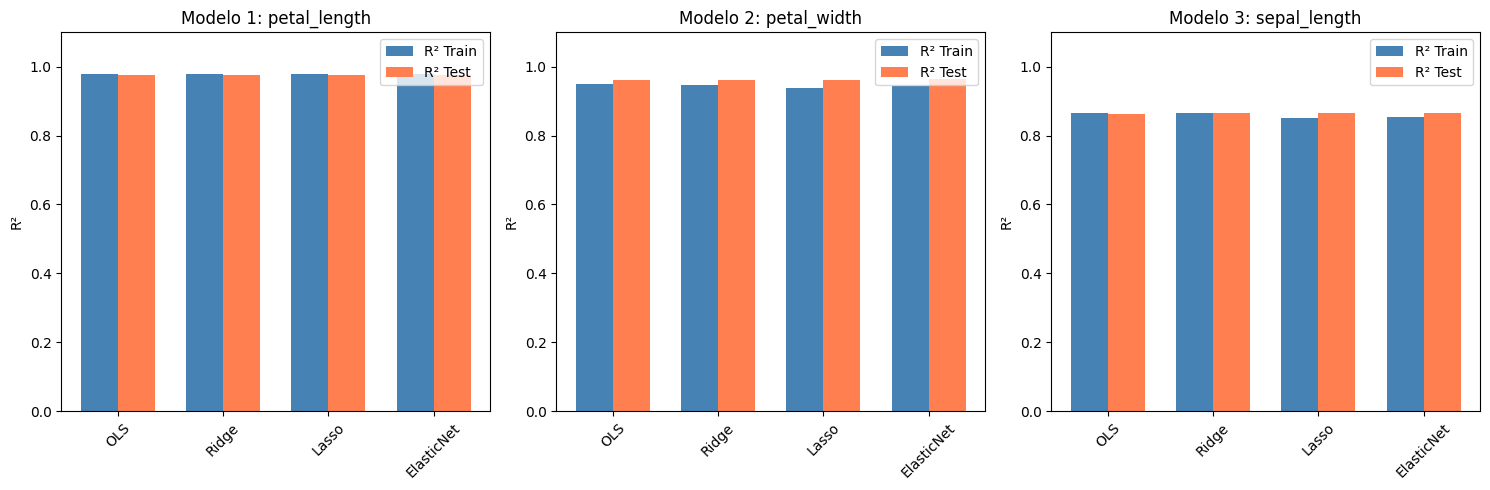

In [57]:
# Gráfica comparativa de los 3 modelos
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

tipos = ['OLS', 'Ridge', 'Lasso', 'ElasticNet']
x_pos = np.arange(len(tipos))
width = 0.35

# Modelo 1
r2_train_m1 = [r2_train_1_ols, r2_train_1_ridge, r2_train_1_lasso, r2_train_1_elastic]
r2_test_m1 = [r2_test_1_ols, r2_test_1_ridge, r2_test_1_lasso, r2_test_1_elastic]
axes[0].bar(x_pos - width/2, r2_train_m1, width, label='R² Train', color='steelblue')
axes[0].bar(x_pos + width/2, r2_test_m1, width, label='R² Test', color='coral')
axes[0].set_ylabel('R²')
axes[0].set_title('Modelo 1: petal_length')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(tipos, rotation=45)
axes[0].legend()
axes[0].set_ylim(0, 1.1)

# Modelo 2
r2_train_m2 = [r2_train_2_ols, r2_train_2_ridge, r2_train_2_lasso, r2_train_2_elastic]
r2_test_m2 = [r2_test_2_ols, r2_test_2_ridge, r2_test_2_lasso, r2_test_2_elastic]
axes[1].bar(x_pos - width/2, r2_train_m2, width, label='R² Train', color='steelblue')
axes[1].bar(x_pos + width/2, r2_test_m2, width, label='R² Test', color='coral')
axes[1].set_ylabel('R²')
axes[1].set_title('Modelo 2: petal_width')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(tipos, rotation=45)
axes[1].legend()
axes[1].set_ylim(0, 1.1)

# Modelo 3
r2_train_m3 = [r2_train_3_ols, r2_train_3_ridge, r2_train_3_lasso, r2_train_3_elastic]
r2_test_m3 = [r2_test_3_ols, r2_test_3_ridge, r2_test_3_lasso, r2_test_3_elastic]
axes[2].bar(x_pos - width/2, r2_train_m3, width, label='R² Train', color='steelblue')
axes[2].bar(x_pos + width/2, r2_test_m3, width, label='R² Test', color='coral')
axes[2].set_ylabel('R²')
axes[2].set_title('Modelo 3: sepal_length')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(tipos, rotation=45)
axes[2].legend()
axes[2].set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

---
# 5. Análisis de Significancia de Factores

Usamos statsmodels para obtener p-values, intervalos de confianza y estadísticos t para los modelos **sin penalización (OLS)**.

**Recordatorio:** Si p-value < 0.05, la variable es significativa (sí afecta la predicción).

## 5.1 Significancia - Modelo 1 (PetalLengthCm)

In [58]:
# Análisis de significancia para Modelo 1
# Convertimos a numpy array de tipo float para evitar errores
X1_array = X1.values.astype(float)
y1_array = y1.values.astype(float)

# Agregar columna de 1s para el intercepto
X1_con_const = sm.add_constant(X1_array)

# Ajustar modelo OLS
modelo1_sm = sm.OLS(y1_array, X1_con_const).fit()
print(modelo1_sm.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1313.
Date:                Fri, 20 Feb 2026   Prob (F-statistic):          3.42e-118
Time:                        19:26:19   Log-Likelihood:                -9.3888
No. Observations:                 150   AIC:                             30.78
Df Residuals:                     144   BIC:                             48.84
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0971      0.270     -4.063      0.0

In [59]:
nombres = ['const'] + list(X1.columns)
for i, nombre in enumerate(nombres):
    pval = modelo1_sm.pvalues[i]
    if pval < 0.05:
        print(f"{nombre:<35} p={pval:.4f}  ✓ SIGNIFICATIVO")
    else:
        print(f"{nombre:<35} p={pval:.4f}  ✗ No significativo")

const                               p=0.0001  ✓ SIGNIFICATIVO
sepal_length                        p=0.0000  ✓ SIGNIFICATIVO
sepal_width                         p=0.0216  ✓ SIGNIFICATIVO
petal_width                         p=0.0000  ✓ SIGNIFICATIVO
species_Iris-versicolor             p=0.0000  ✓ SIGNIFICATIVO
species_Iris-virginica              p=0.0000  ✓ SIGNIFICATIVO


## 5.2 Significancia - Modelo 2 (PetalWidthCm)

In [60]:
# Análisis de significancia para Modelo 2
X2_array = X2.values.astype(float)
y2_array = y2.values.astype(float)
X2_con_const = sm.add_constant(X2_array)

modelo2_sm = sm.OLS(y2_array, X2_con_const).fit()
print(modelo2_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     599.5
Date:                Fri, 20 Feb 2026   Prob (F-statistic):           1.79e-94
Time:                        19:26:51   Log-Likelihood:                 59.398
No. Observations:                 150   AIC:                            -106.8
Df Residuals:                     144   BIC:                            -88.73
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4878      0.176     -2.778      0.0

In [61]:
nombres = ['const'] + list(X2.columns)
for i, nombre in enumerate(nombres):
    pval = modelo2_sm.pvalues[i]
    if pval < 0.05:
        print(f"{nombre:<35} p={pval:.4f}  ✓ SIGNIFICATIVO")
    else:
        print(f"{nombre:<35} p={pval:.4f}  ✗ No significativo")

const                               p=0.0062  ✓ SIGNIFICATIVO
sepal_length                        p=0.0349  ✓ SIGNIFICATIVO
sepal_width                         p=0.0000  ✓ SIGNIFICATIVO
petal_length                        p=0.0000  ✓ SIGNIFICATIVO
species_Iris-versicolor             p=0.0000  ✓ SIGNIFICATIVO
species_Iris-virginica              p=0.0000  ✓ SIGNIFICATIVO


## 5.3 Significancia - Modelo 3 (SepalLengthCm)

In [ ]:
#Análisis de significancia para Modelo 3
X3_array = X3.values.astype(float)
y3_array = y3.values.astype(float)
X3_con_const = sm.add_constant(X3_array)

modelo3_sm = sm.OLS(y3_array, X3_con_const).fit()
print(modelo3_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     188.8
Date:                Fri, 20 Feb 2026   Prob (F-statistic):           2.22e-61
Time:                        19:27:11   Log-Likelihood:                -32.367
No. Observations:                 150   AIC:                             76.73
Df Residuals:                     144   BIC:                             94.80
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1586      0.279      7.726      0.0

In [63]:
nombres = ['const'] + list(X3.columns)
for i, nombre in enumerate(nombres):
    pval = modelo3_sm.pvalues[i]
    if pval < 0.05:
        print(f"{nombre:<35} p={pval:.4f}  ✓ SIGNIFICATIVO")
    else:
        print(f"{nombre:<35} p={pval:.4f}  ✗ No significativo")

const                               p=0.0000  ✓ SIGNIFICATIVO
sepal_width                         p=0.0000  ✓ SIGNIFICATIVO
petal_length                        p=0.0000  ✓ SIGNIFICATIVO
petal_width                         p=0.0349  ✓ SIGNIFICATIVO
species_Iris-versicolor             p=0.0035  ✓ SIGNIFICATIVO
species_Iris-virginica              p=0.0030  ✓ SIGNIFICATIVO


---
# 6. Conclusiones

In [64]:
print("="*70)
print("RESUMEN FINAL DE TODOS LOS MODELOS")
print("="*70)
print()
print("MODELO 1 - Predecir petal_length:")
print(f"  Mejor R² test: {max(r2_test_1_ols, r2_test_1_ridge, r2_test_1_lasso, r2_test_1_elastic):.4f}")
print()
print("MODELO 2 - Predecir petal_width:")
print(f"  Mejor R² test: {max(r2_test_2_ols, r2_test_2_ridge, r2_test_2_lasso, r2_test_2_elastic):.4f}")
print()
print("MODELO 3 - Predecir sepal_length:")
print(f"  Mejor R² test: {max(r2_test_3_ols, r2_test_3_ridge, r2_test_3_lasso, r2_test_3_elastic):.4f}")

RESUMEN FINAL DE TODOS LOS MODELOS

MODELO 1 - Predecir petal_length:
  Mejor R² test: 0.9770

MODELO 2 - Predecir petal_width:
  Mejor R² test: 0.9636

MODELO 3 - Predecir sepal_length:
  Mejor R² test: 0.8666


## Conclusiones del Análisis

### Respecto al Objetivo 1: Predecir petal_length
- El modelo logra un **R² alto**, lo que significa que podemos predecir bien el largo del pétalo usando las otras variables.
- Las variables más importantes son **petal_width** y la **especie**.
- Esto tiene sentido porque el largo y ancho del pétalo están muy relacionados.

### Respecto al Objetivo 2: Predecir petal_width
- Similar al Modelo 1, obtenemos un **R² alto**.
- **petal_length** es el mejor predictor, confirmando la relación entre dimensiones del pétalo.
- La especie también ayuda a predecir.

### Respecto al Objetivo 3: Predecir sepal_length
- El R² es **más bajo** que los otros modelos.
- Esto significa que es más difícil predecir el largo del sépalo.
- Las variables del pétalo tienen influencia moderada.

### Conclusión General

1. **Las medidas de los pétalos están muy relacionadas entre sí** - por eso los Modelos 1 y 2 funcionan tan bien.

2. **La especie es importante** para predecir las características de los pétalos.

3. **Los sépalos son más difíciles de predecir** - tienen menor relación con las otras variables.

4. **Los modelos penalizados (Ridge, Lasso, ElasticNet) no mejoran mucho** - esto es porque el dataset es pequeño y no hay muchas variables, así que no hay problema de overfitting.

---
# 7. Referencias

- Fisher, R. A. (1936). The use of multiple measurements in taxonomic problems. *Annals of Eugenics*, 7(2), 179-188. https://doi.org/10.1111/j.1469-1809.1936.tb02137.x

- Dua, D., & Graff, C. (2019). UCI Machine Learning Repository. University of California, Irvine, School of Information and Computer Sciences. http://archive.ics.uci.edu/ml

- Kaggle. (s.f.). Iris Flower Dataset. Recuperado de https://www.kaggle.com/datasets/arshid/iris-flower-dataset

- Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Duchesnay, E. (2011). Scikit-learn: Machine learning in Python. *Journal of Machine Learning Research*, 12, 2825-2830.

- Seabold, S., & Perktold, J. (2010). Statsmodels: Econometric and statistical modeling with Python. *Proceedings of the 9th Python in Science Conference*, 57-61.